**Reinforcement Learning with TensorFlow & TRFL: V-Trace**

Outline:
1. V-Trace
* TRFL Usage: trfl.vtrace_from_logits() with CartPole


In [0]:
#TRFL works with TensorFlow 1.12
#installs TensorFlow version 1.12 then restarts the runtime
!pip install tensorflow==1.12

import os
os.kill(os.getpid(), 9)

In [0]:
#install tensorflow-probability 0.5.0 that works with TensorFlow 1.12
!pip install tensorflow-probability==0.5.0

#install TRFL
!pip install trfl==1.0

In [0]:
import gym
import tensorflow as tf
import trfl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

** V-trace ** 

V-trace is used in IMPALA to correct for the off-policyness of the data. Since the actors are decoupled from the learner and gather experience asynchronously to the learner’s updating, the trajectories of experience may lag and be off-policy. Ie the actors may be gathering experience with a different trajectory than the current learner. Thus an off-policy correction algorithm like V-trace is needed. V-trace is similar to Retrace. Unlike Retrace, in the on policy case, V-trace reduces to TD(λ).

** CartPole with V-Trace **

In [0]:
class PolicyVFNetwork:
  def __init__(self, name, policy_lr=0.001, vf_lr=0.002, obs_size=2, action_size=3, policy_hidden=64, vf_hidden=64, 
               entropy_coefficient=0.0001, clip_rho_threshold=1.0, clip_pg_rho_threshold=1.0):
    
    with tf.variable_scope(name):
      self.name=name
      # input tensors
      self.input_ = tf.placeholder(tf.float32, [None, obs_size], name='input')
      self.action_ = tf.placeholder(tf.int32, [None, 1], name='action')
      self.discount_ = tf.placeholder(tf.float32, [None, 1], name='discount')
      self.reward_ = tf.placeholder(tf.float32, [None, 1], name='reward')
      self.bootstrap_ = tf.placeholder(tf.float32, [None], name='bootstrap')
      self.behaviour_policy_ = tf.placeholder(tf.float32, [None, 1, action_size], name='behaviour_policy')
      
      # set up policy network
      self.policy_fc1_ = tf.contrib.layers.fully_connected(self.input_, policy_hidden, activation_fn=tf.nn.relu)
      self.policy_fc2_ = tf.contrib.layers.fully_connected(self.policy_fc1_, policy_hidden, activation_fn=tf.nn.relu)
      self.policy_fc3_ = tf.contrib.layers.fully_connected(self.policy_fc2_, action_size, activation_fn=None)
      self.policy_out_ = tf.reshape(self.policy_fc3_, [-1, 1, action_size])
      
      # generate action probabilities for taking actions
      self.action_prob_ = tf.nn.softmax(self.policy_fc3_)
      
      # set up value function network
      self.vf_fc1_ = tf.contrib.layers.fully_connected(self.input_, vf_hidden, activation_fn=tf.nn.relu)
      self.vf_fc2_ = tf.contrib.layers.fully_connected(self.vf_fc1_, vf_hidden, activation_fn=tf.nn.relu)
      self.vf_out_ = tf.contrib.layers.fully_connected(self.vf_fc2_, 1, activation_fn=None)
      
      # TRFL V-trace usage
      self.vtrace_return_ = trfl.vtrace_from_logits(behaviour_policy_logits=self.behaviour_policy_, 
                        target_policy_logits=self.policy_out_, actions=self.action_, discounts=self.discount_, 
                        rewards=self.reward_, values=self.vf_out_, bootstrap_value=self.bootstrap_, 
                        clip_rho_threshold=clip_rho_threshold, clip_pg_rho_threshold=clip_pg_rho_threshold)
      
      # optimize the policy loss with V-trace policy gradient advantages
      self.pg_loss_ = trfl.discrete_policy_gradient_loss(self.policy_out_, self.action_, self.vtrace_return_.pg_advantages) 
      self.entropy_loss_, _ = trfl.discrete_policy_entropy_loss(self.policy_fc3_, normalise=True)
      self.combined_loss_ = self.pg_loss_ + entropy_coefficient * self.entropy_loss_
      self.policy_loss_ = tf.reduce_mean(self.combined_loss_)
      self.policy_optim_ = tf.train.AdamOptimizer(learning_rate=policy_lr).minimize(self.policy_loss_)
      
      # optimize the value function with V-trace vs
      self.vf_loss_ = tf.losses.mean_squared_error(self.vf_out_, self.vtrace_return_.vs)
      self.vf_optim_ = tf.train.AdamOptimizer(learning_rate=vf_lr).minimize(self.vf_loss_)

  def get_network_variables(self):
    return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]

** TRFL Usage **

We set up an actor-critic like network, with a policy net to generate the target probabilities and a value function network for the values. We feed the target policy logits and the value function output into trfl.vtrace_from_logits() along with the input tensors. Using the V-trace return, we optimize the policy net with the pg_advantages return and the value function with the vs return

In [0]:
# hyperparameters
discount = 0.99
train_episodes = 5000                     
policy_hidden_size = 32
vf_hidden_size = 32
policy_learning_rate = 0.0001
vf_learning_rate = 0.001
entropy_coefficient = 0.00001
update_tau = 0.001
update_behaviour_every = 10
clip_rho_threshold = 1.0
clip_pg_rho_threshold = 1.0

stats_every = 10
evaluate_every = 20 # evaluate the learning net after this main episodes
evaluate_ep = 100   # evaluate the learning net for this many episodes

seed = 31
env = gym.make('CartPole-v0')
env.seed(seed)
np.random.seed(seed)

action_size = env.action_space.n
obs_size = env.observation_space.shape[0]

tf.reset_default_graph()
tf.set_random_seed(seed)

# Create networks
train_net = PolicyVFNetwork(name='train_net', policy_lr=policy_learning_rate, vf_lr=vf_learning_rate, obs_size=obs_size,
                       action_size=action_size, policy_hidden=policy_hidden_size, vf_hidden=vf_hidden_size,
                       entropy_coefficient=entropy_coefficient, clip_rho_threshold=1.0, clip_pg_rho_threshold=1.0)
behaviour_net = PolicyVFNetwork(name='behaviour_net', policy_lr=policy_learning_rate, vf_lr=vf_learning_rate, obs_size=obs_size,
                       action_size=action_size, policy_hidden=policy_hidden_size, vf_hidden=vf_hidden_size,
                       entropy_coefficient=entropy_coefficient, clip_rho_threshold=1.0, clip_pg_rho_threshold=1.0)
vf_target_net = PolicyVFNetwork(name='vf_target_net', policy_lr=policy_learning_rate, vf_lr=vf_learning_rate, obs_size=obs_size,
                       action_size=action_size, policy_hidden=policy_hidden_size, vf_hidden=vf_hidden_size,
                       entropy_coefficient=entropy_coefficient, clip_rho_threshold=1.0, clip_pg_rho_threshold=1.0)

# target network updating
target_network_update_op = trfl.update_target_variables(vf_target_net.get_network_variables(), 
                                                         train_net.get_network_variables(), tau=update_tau)
behaviour_update_op = trfl.update_target_variables(behaviour_net.get_network_variables(), 
                                                         train_net.get_network_variables(), tau=1.0)


In [0]:
stats_list = []
stats_eval_list = []
eval_episode = 0
stop_after_eval = False

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for ep in range(1, train_episodes):
      if stop_after_eval:
        break
      total_reward = 0
      ep_length = 0
      state = env.reset() 
      done = 0

      # store trajectories in lists, use trajectories to train agent
      obs_list, rew_list, action_list, logits_list, policy_loss_list, vf_loss_list = [], [], [], [], [], []

      while not done:
          # generate action probabilities from behaviour net policy probs and sample from the action probs
          action_probs, behaviour_logits = sess.run([behaviour_net.action_prob_, behaviour_net.policy_out_],
                                                     feed_dict={behaviour_net.input_:np.expand_dims(state,axis=0)})
          action_probs = action_probs[0]
          action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
          behaviour_logits = behaviour_logits[0]

          obs_list.append(state)
          action_list.append(action)
          logits_list.append(behaviour_logits)

          state, reward, done, info = env.step(action)
          total_reward += reward
          ep_length += 1
          rew_list.append(reward)

          # bootstrap value for next state using behaviour net value function
          if done:
            bootstrap_value = 0.
          else:
            bootstrap_value = sess.run(vf_target_net.vf_out_, feed_dict={
                  vf_target_net.input_:np.reshape(state,(1,-1)),
              })
            bootstrap_value = bootstrap_value[0]

          feed_dict = { 
              train_net.input_:np.array(obs_list),
              train_net.action_:np.array(action_list).reshape(-1,1),
              train_net.discount_:np.array([discount]*len(rew_list)).reshape(-1,1),
              train_net.reward_:np.array(rew_list).reshape(-1,1),
              train_net.bootstrap_:np.array(bootstrap_value).reshape((1,)),
              train_net.behaviour_policy_:np.array(logits_list)
          }
          # run the optimizers to get the V-trace return and update the networks
          _, _, stats_policy_loss, stats_vf_loss = sess.run([train_net.policy_optim_, train_net.vf_optim_, 
                                                             train_net.policy_loss_, train_net.vf_loss_],
                                                            feed_dict=feed_dict)
          policy_loss_list.append(stats_policy_loss)
          vf_loss_list.append(stats_vf_loss)

          # update target network
          sess.run(target_network_update_op)
          
          # update behaviour network
          if ep % update_behaviour_every == 0:
            sess.run(behaviour_update_op)

          if done:
            if ep % stats_every == 0:
              print('Episode: {}'.format(ep),
                    'Total reward: {:.1f}'.format(np.mean(stats_list[-stats_every:],axis=0)[1]),
                    'Ep length: {:.1f}'.format(np.mean(stats_list[-stats_every:],axis=0)[2]),
                    'Policy Loss: {:.4f}'.format(np.mean(policy_loss_list)),
                    'VF Loss: {:.4f}'.format(np.mean(vf_loss_list)))
            stats_list.append((ep, total_reward, ep_length))

            # evaluate performance every evaluate_every episodes
            if ep % evaluate_every == 0:
              for i in range(evaluate_ep):
                state = env.reset()
                total_reward = 0
                total_len = 0
                done = 0
                eval_episode += 1

                while not done:
                  action_probs = sess.run(train_net.action_prob_,
                                                     feed_dict={train_net.input_:np.expand_dims(state,axis=0)})
                  action_probs = action_probs[0]
                  action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
                  state, rew, done, info = env.step(action)
                  total_reward += rew
                  total_len += 1

                  if done:
                    stats_eval_list.append((eval_episode, total_reward, total_len, ep))

              print("Evaluation at Episode {}: Avg Rew, Len: {:.2f}, {:.2f} ".format(ep, 
                                                                           np.mean(stats_eval_list[-evaluate_ep:],axis=0)[1],
                                                                           np.mean(stats_eval_list[-evaluate_ep:],axis=0)[2]))

              # stop episodes when agent is able to solve game
              if np.mean(stats_eval_list[-evaluate_ep:],axis=0)[1] > 190:
                print("Stopping at episode {} with average rewards of {} in last {} episodes".
                      format(ep, np.mean(stats_eval_list[-evaluate_ep:],axis=0)[1], evaluate_ep))
                stop_after_eval = True
                
                

Episode: 10 Total reward: 19.8 Ep length: 19.8 Policy Loss: -9.4118 VF Loss: 22.9299
Episode: 20 Total reward: 22.8 Ep length: 22.8 Policy Loss: -5.0912 VF Loss: 11.5798
Evaluation at Episode 20: Avg Rew, Len: 28.09, 28.09 
Episode: 30 Total reward: 25.6 Ep length: 25.6 Policy Loss: 60.7666 VF Loss: 61.3643
Episode: 40 Total reward: 39.3 Ep length: 39.3 Policy Loss: 27.0989 VF Loss: 56.1596
Evaluation at Episode 40: Avg Rew, Len: 44.71, 44.71 
Episode: 50 Total reward: 41.3 Ep length: 41.3 Policy Loss: 26.7341 VF Loss: 178.9703
Episode: 60 Total reward: 46.4 Ep length: 46.4 Policy Loss: 163.2442 VF Loss: 95.5574
Evaluation at Episode 60: Avg Rew, Len: 61.84, 61.84 
Episode: 70 Total reward: 57.6 Ep length: 57.6 Policy Loss: 80.7805 VF Loss: 109.1420
Episode: 80 Total reward: 65.9 Ep length: 65.9 Policy Loss: 79.8347 VF Loss: 90.7948
Evaluation at Episode 80: Avg Rew, Len: 76.26, 76.26 
Episode: 90 Total reward: 102.6 Ep length: 102.6 Policy Loss: -9.3316 VF Loss: 48.4003
Episode: 100 T

Text(0, 0.5, 'Total Reward')

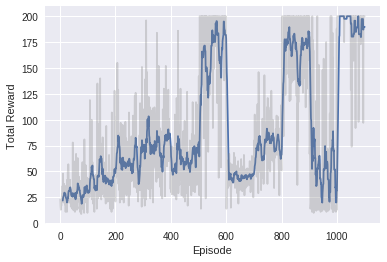

In [0]:
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews, lens, ep = np.array(stats_eval_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')